# Market Learning
*Leveraging machine learning to help you learn the market and invest your money*

### Objective
The Market Learning tool is intended to provide an adaptive, fact-based introduction of the stock markets to a user with limited experience with personal investment decisions. This project is for people who are interested in understanding the stock market but don't want to spend much time worrying about it and any investments they have in it. This presentation is not intended to be a neat summary of my insights but a walkthrough of my process, which was sometimes messy, in exploring and analyzing the data, so that my audience can actually understand where my conclusions come from and make their own conclusions with the benefit of my experience. This report does not offer investment advice or any financial advice, as individuals must be completely responsible for their financial choices. This report contains the my opinions which seek to offer educational value to others. The ultimate objective of the Market Learning tool is to help me understand the market in order to invest my own money. 

**Developer Updates**

Expected v1.0 launch 2023-05-05

2023-05-03: *behind schedule, will not have adaptability or UI ready by v1.0 launch*


### Overview

Outline
- Data Collection
- Data Cleaning
- Visualization
- Prediction
- Conclusion

**Introduction**

The stock market is made of organized exchanges, like New York Stock Exchange and Nasdaq. 
The exchanges function as markets for the stocks listed on them, letting people buy and sell shares of stocks.
Most people need to use an intermediary broker to actually trade on an exchange. 
Stocks are a type of security that represent ownership shares in a company. 
There are also other types of securities on the market exchanges, notably funds. 

To represent averages and different segments of the market, people use indexes. 
An index value is a calculation (ie an average) from the prices of the stocks in that index.
One long-term measure of a security's value as an investment is how it compares to the major index values. 
Interestingly, many stocks and financial experts fail to "beat" the index in the long term. 

I'm going to start by ignoring short-term stuff. My goal is to find reliable long term investments without much time thinking about it. 

In [2]:
from enum import Enum
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


### Data Collection

First, I scrape a list of names and acronyms of 11,000+ stocks and other securities from Nasdaq. 

In [62]:
nasdaq_url = 'http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqtraded.txt'
page_data = pd.read_csv(nasdaq_url, sep='|')
page_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504 entries, 0 to 11503
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     11504 non-null  object 
 1   Symbol            11502 non-null  object 
 2   Security Name     11503 non-null  object 
 3   Listing Exchange  11503 non-null  object 
 4   Market Category   11503 non-null  object 
 5   ETF               11503 non-null  object 
 6   Round Lot Size    11503 non-null  float64
 7   Test Issue        11503 non-null  object 
 8   Financial Status  5284 non-null   object 
 9   CQS Symbol        6219 non-null   object 
 10  NASDAQ Symbol     11502 non-null  object 
 11  NextShares        11503 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.1+ MB


Then I clean this data to isolate the acronyms, which are all I will use. 

In [63]:
# Look for null values
page_data[page_data['Symbol'].isna()]
# There are only 2 rows with null symbols, and I can remove them both. 
page_data = page_data[page_data['Symbol'].notna()]
page_data.info()

# Override the variable page_data with just a series of the symbols - may improve memory use
page_data = page_data['Symbol']
# page_data.info()
page_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11502 entries, 0 to 11502
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     11502 non-null  object 
 1   Symbol            11502 non-null  object 
 2   Security Name     11502 non-null  object 
 3   Listing Exchange  11502 non-null  object 
 4   Market Category   11502 non-null  object 
 5   ETF               11502 non-null  object 
 6   Round Lot Size    11502 non-null  float64
 7   Test Issue        11502 non-null  object 
 8   Financial Status  5283 non-null   object 
 9   CQS Symbol        6219 non-null   object 
 10  NASDAQ Symbol     11502 non-null  object 
 11  NextShares        11502 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.1+ MB


0       A
1      AA
2     AAA
3    AAAU
4     AAC
Name: Symbol, dtype: object

I also get a list of 400 mutual funds from morningstar 

In [83]:
funds = []
for i in range(1,5):
    page = requests.get(f'https://www.morningstar.com/index-funds?page={i}')
    if (page.status_code == 200):
        soup = bs(page.content, 'html.parser')
        fund_links = soup.select('.mdc-table__content a')
        for item in fund_links:
            funds.append(item.get('href').split('/')[3].upper())
    else:
        print(f'Error: {i}, {page.status_code}')
len(funds), funds[0]

(400, 'ABRVX')

I also get the names of 36 indexes from Google Finance

In [87]:
page_google = requests.get('https://www.google.com/finance/markets/indexes/americas')
page_google.status_code
soup = bs(page_google.content, 'html.parser')
index_acronyms = []
for item in soup.select('ul a'):
    index_acr = item.get('href').split('/')[2].split(':')[0]
    if '.' in index_acr:
        index_acr = index_acr.replace('.', '^')
    index_acronyms.append(index_acr)
len(index_acronyms), index_acronyms[0]

(36, '^INX')

I use the yfinance library to instantiate a Ticker object from my list of acronyms. yfinance uses Yahoo Finance's API to get financial data. This cell doesn't immediately give me a dataset of security financial history, but it instantiates a yfinance Ticker object where I can get that. 

Information on yfinance is available at: 'https://pypi.org/project/yfinance/'.

In [88]:
ticker_objects = yf.Tickers(' '.join(page_data.tolist()))
fund_objects = yf.Tickers(' '.join(funds))
index_tickers = yf.Tickers(' '.join(index_acronyms))
len(ticker_objects.tickers)  # 11,511 ticker objects

11502

Then I explore one Ticker object to understand what I received from yfinance, and to see what it gives for financial data with the .history() method.

In [10]:
ticker_objects.tickers['AAPL'].info
# ticker_objects.tickers['AAPL'].recommendations

# Get the history of one stock
df_aapl = ticker_objects.tickers['AAPL'].history(period='max', repair=False)
df_aapl.info(), df_aapl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10688 entries, 1980-12-12 00:00:00-05:00 to 2023-05-04 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10688 non-null  float64
 1   High          10688 non-null  float64
 2   Low           10688 non-null  float64
 3   Close         10688 non-null  float64
 4   Volume        10688 non-null  int64  
 5   Dividends     10688 non-null  float64
 6   Stock Splits  10688 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 668.0 KB


(None,
                                Open      High       Low     Close     Volume   
 Date                                                                           
 1980-12-12 00:00:00-05:00  0.099722  0.100155  0.099722  0.099722  469033600  \
 1980-12-15 00:00:00-05:00  0.094953  0.094953  0.094519  0.094519  175884800   
 1980-12-16 00:00:00-05:00  0.088015  0.088015  0.087582  0.087582  105728000   
 1980-12-17 00:00:00-05:00  0.089749  0.090183  0.089749  0.089749   86441600   
 1980-12-18 00:00:00-05:00  0.092351  0.092785  0.092351  0.092351   73449600   
 
                            Dividends  Stock Splits  
 Date                                                
 1980-12-12 00:00:00-05:00        0.0           0.0  
 1980-12-15 00:00:00-05:00        0.0           0.0  
 1980-12-16 00:00:00-05:00        0.0           0.0  
 1980-12-17 00:00:00-05:00        0.0           0.0  
 1980-12-18 00:00:00-05:00        0.0           0.0  )

I'll need to clean the data a little bit to make sure my dataframe contains the security type and acronym and to reduce its size. 

In [73]:
# I'll try to directly define integers to represent different security classifications, instead of strings. I know that some ML algorithms do this, and others like target encoding prefer to see the whole dataset before prescribing numbers for classifications, so they can be a little smarter about it. 
# I may need to revisit this later.
class SecurityType(Enum):
    EQUITY = 1
    ETF = 2
    MUTUALFUND = 3
    INDEX = 4
    CURRENCY = 5
    FUTURE = 6
    CRYPTO = 7
    ECNQUOTE = 8

I download the financial data for all of my securities. I clean each security's data while downloading it to improve memory use and performance. 

This first cell took 1.5 hours to run and returned a dataframe of approximately 2 GB. I can't rerun this whenever I want, so I need to save this data and move forward from here. 

In [33]:
# Repeat this process for all tickers
lst_dfs = []
for ticker in ticker_objects.tickers:
    try:
        # Download the data for each ticker
        df = ticker_objects.tickers[ticker].history(period='max', interval='1mo', repair=True)
    except Exception as e: 
        print(f'Error: {ticker}, {e}')
        continue
    if df.empty:
        # I could also remove it from the list of acronyms if that's useful
        continue

    # Add the ticker's major info to the dataframe
    df['Security Type'] = SecurityType[ticker_objects.tickers[ticker].info['quoteType']].value
    df['Security Type'] = df['Security Type'].astype('int64')
    df['Acronym'] = ticker 
    df['Acronym'] = df['Acronym'].astype('string') # I don't think this actually improved memory usage
#     df['Exchange'] = ticker_objects.tickers[ticker].info['exchange']
#     df['Industry'] = ticker_objects.tickers[ticker].info['industry']
#     df['Sector'] = ticker_objects.tickers[ticker].info['sector']


    # Edits I've made after running this cell
    df.rename(columns={'Close': 'Price'}, inplace=True)
    df.reset_index(inplace=True)
    if 'Capital Gains' not in df.columns:
        df['Capital Gains'] = np.nan
    df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Capital Gains', 'Stock Splits'], inplace=True, axis=1)

    lst_dfs.append(df)
df_all = pd.concat(lst_dfs)

Got error from yahoo api for ticker AAC.U, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAC.U: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAC.W, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAC.W: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AACT.U, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AACT.U: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAIC$B, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAIC$B: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAIC$C, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- AAIC$C: No timezone found, symbol may be delisted
Got error from yahoo api for ticker AAM$A, Error: {'code': 'Not Found', 'description': 'No data fou

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [34]:
# History for mutual funds
lst_funds = []
for fund in funds:
    df = fund_objects.tickers[fund].history(period='max', interval='1d', repair=True)

    if df.empty:
        continue

    df['Security Type'] = SecurityType[fund_objects.tickers[fund].info['quoteType']].value
    df['Acronym'] = fund
    df['Acronym'] = df['Acronym'].astype('string') 
    
    df.rename(columns={'Close': 'Price'}, inplace=True)
    df.reset_index(inplace=True)
    if 'Capital Gains' not in df.columns:
        df['Capital Gains'] = np.nan
    df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Capital Gains', 'Stock Splits'], inplace=True, axis=1)

    lst_funds.append(df)
len(lst_funds)

400

In [64]:
df_funds = pd.concat(lst_funds)
df_funds.head()
df_funds['Security Type'].value_counts()

Security Type
3    1629022
Name: count, dtype: int64

In [89]:
# History for indexes
lst_indexes = []
for index in index_acronyms:
    df = index_tickers.tickers[index].history(period='max', interval='1d', repair=True)

    if df.empty:
        continue
    
    df['Security Type'] = SecurityType[index_tickers.tickers[index].info['quoteType']].value
    df['Acronym'] = index
    df['Acronym'] = df['Acronym'].astype('string') 
    
    df.rename(columns={'Close': 'Price'}, inplace=True)
    df.reset_index(inplace=True)
    if 'Capital Gains' not in df.columns:
        df['Capital Gains'] = np.nan
    df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Capital Gains', 'Stock Splits'], inplace=True, axis=1)

    lst_indexes.append(df)
len(lst_indexes)

^INX: 1d data not available for startTime=-2208994789 and endTime=1683250727. Only 100 years worth of day granularity data are allowed to be fetched per request.
Got error from yahoo api for ticker OSPTX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- OSPTX: No timezone found, symbol may be delisted
Got error from yahoo api for ticker IBOV, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- IBOV: No timezone found, symbol may be delisted
DJU: No data found for this date range, symbol may be delisted
YF: WARNING: Cannot reconstruct because Yahoo not returning data in interval
DJU: No data found for this date range, symbol may be delisted
YF: WARNING: Cannot reconstruct because Yahoo not returning data in interval
Got error from yahoo api for ticker SPLAC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- SPLAC: No timezone found, symbol may be delisted
Got error from yahoo ap

18

In [90]:
df_indexes = pd.concat(lst_indexes)
df_indexes.info()
df_indexes.head()

<class 'pandas.core.frame.DataFrame'>
Index: 85048 entries, 0 to 1
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Date           85048 non-null  datetime64[ns, America/New_York]
 1   Price          85048 non-null  float64                         
 2   Dividends      85048 non-null  float64                         
 3   Security Type  85048 non-null  int64                           
 4   Acronym        85048 non-null  string                          
dtypes: datetime64[ns, America/New_York](1), float64(2), int64(1), string(1)
memory usage: 3.9 MB


,Date,Price,Dividends,Security Type,Acronym
0,1992-01-02 00:00:00-05:00,3172.399902,0.0,4,^DJI
1,1992-01-03 00:00:00-05:00,3201.500000,0.0,4,^DJI
2,1992-01-06 00:00:00-05:00,3200.100098,0.0,4,^DJI
3,1992-01-07 00:00:00-05:00,3204.800049,0.0,4,^DJI
4,1992-01-08 00:00:00-05:00,3203.899902,0.0,4,^DJI


Because I'm running this notebook again after already downloading the data and cleaning it and saving it, shown in the cells below, I'm just going to fetch the .csv file I stored. 

In [37]:
df_all = pd.read_csv('market_data.csv')
# df_all['Acronym'].value_counts() # 10,118 unique stocks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   Date           object 
 2   Price          float64
 3   Dividends      float64
 4   Security Type  int64  
 5   Acronym        object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ GB


In [38]:
df_all.drop('Unnamed: 0', axis=1, inplace=True)
df_all['Acronym'].value_counts() # 10,118 unique stocks

Acronym
FL      15439
DTE     15439
XOM     15439
KO      15439
BP      15439
        ...  
MAYW        2
TRNR        2
SBXC        2
DOGG        2
TMTC        2
Name: count, Length: 10118, dtype: int64

### Data Cleaning
First, I check for null values

In [39]:
df_all.isna().sum()
# df_all[df_all['Close'].isna()]

Date             0
Price            1
Dividends        0
Security Type    0
Acronym          0
dtype: int64

In [49]:
df_all[df_all['Price'].isna()]
# df_all['Price'].dropna(inplace=True) # this didn't work
# del df_all.iloc[13308703] # this didn't work
df_all.dropna(subset=['Price'], inplace=True) # this worked
df_all[df_all['Price'].isna()]


,Date,Price,Dividends,Security Type,Acronym


I want to have a normal index instead of the Date Index.

In [118]:
df_all.index
# df_all['Date'] = df_all.index # this was a mistake
df_all.head()
df_all.info()
# df_all.reset_index(inplace=True) # this doesn't work now
# df_all = df_all.reset_index() # still doesn't work, because of that mistake
df_all.head()
# df_all.drop(columns=['Date'], inplace=True)
df_all.head()
df_all.reset_index() # this looks good
df_all.reset_index(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 5 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Security Type  int16                           
 4   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(2), int16(1), string(1)
memory usage: 1012.0 MB


In [120]:
df_all['Date']

0          1999-11-18 00:00:00-05:00
1          1999-11-19 00:00:00-05:00
2          1999-11-22 00:00:00-05:00
3          1999-11-23 00:00:00-05:00
4          1999-11-24 00:00:00-05:00
                      ...           
31209488   2023-04-26 00:00:00-04:00
31209489   2023-04-27 00:00:00-04:00
31209490   2023-04-28 00:00:00-04:00
31209491   2023-05-01 00:00:00-04:00
31209492   2023-05-02 00:00:00-04:00
Name: Date, Length: 31209493, dtype: datetime64[ns, America/New_York]

In [31]:
df_all.rename(columns={'Close': 'Price'}, inplace=True)
df_all.head()

,Date,Price,Dividends,Security Type,Acronym
0,1999-11-18 00:00:00-05:00,26.845926,0.0,1,A
1,1999-11-19 00:00:00-05:00,24.634188,0.0,1,A
2,1999-11-22 00:00:00-05:00,26.845926,0.0,1,A
3,1999-11-23 00:00:00-05:00,24.405388,0.0,1,A
4,1999-11-24 00:00:00-05:00,25.053656,0.0,1,A


I'm not sure what the Stock Splits column is useful for

In [100]:
df_all[df_all['Stock Splits'] != 0]
df_all[3762-10:3762+10]

,Date,Close,Volume,Dividends,Stock Splits,Security Type,Acronym
3752,2014-10-20 00:00:00-04:00,34.834961,6909196,0.0,0.000,1,A
3753,2014-10-21 00:00:00-04:00,35.932903,3120196,0.0,0.000,1,A
3754,2014-10-22 00:00:00-04:00,35.300758,3021218,0.0,0.000,1,A
3755,2014-10-23 00:00:00-04:00,35.739937,2453071,0.0,0.000,1,A
3756,2014-10-24 00:00:00-04:00,35.966179,2108464,0.0,0.000,1,A
3757,2014-10-27 00:00:00-04:00,35.926258,1545209,0.0,0.000,1,A
3758,2014-10-28 00:00:00-04:00,36.372082,2394774,0.0,0.000,1,A
3759,2014-10-29 00:00:00-04:00,36.265621,2074213,0.0,0.000,1,A
3760,2014-10-30 00:00:00-04:00,36.145836,2883794,0.0,0.000,1,A
3761,2014-10-31 00:00:00-04:00,36.784649,2918744,0.0,0.000,1,A


Volume of a stock is "the amount of an asset or security that changes hands over some period of time, often over the course of a day" (investopedia.com). It's said to be useful for indicating the significance of daily price moves. 

I'm removing Volume, along with the other day-to-day indicators like High and Low, in an attempt to find more long-term patterns that are useful for investing. However it's possible that actively "playing the stock market game" on a day-to-day level is an effective strategy, and I may revisit it at a later time. 

In [101]:
df_all.drop(columns=['Volume'], inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 6 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Stock Splits   float64                         
 4   Security Type  int16                           
 5   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(3), int16(1), string(1)
memory usage: 1.2 GB


In [110]:
i = 15254
df_all[df_all['Stock Splits'] != 0]
df_all[i-5:i+5]

,Date,Close,Dividends,Stock Splits,Security Type,Acronym
15249,1999-02-19 00:00:00-05:00,36.254177,0.0,0.0,1,AA
15250,1999-02-22 00:00:00-05:00,36.336056,0.0,0.0,1,AA
15251,1999-02-23 00:00:00-05:00,36.144966,0.0,0.0,1,AA
15252,1999-02-24 00:00:00-05:00,36.254177,0.0,0.0,1,AA
15253,1999-02-25 00:00:00-05:00,35.899254,0.0,0.0,1,AA
15254,1999-02-26 00:00:00-05:00,35.380581,0.0,2.0,1,AA
15255,1999-03-01 00:00:00-05:00,36.144966,0.0,0.0,1,AA
15256,1999-03-02 00:00:00-05:00,34.616180,0.0,0.0,1,AA
15257,1999-03-03 00:00:00-05:00,33.851788,0.0,0.0,1,AA
15258,1999-03-04 00:00:00-05:00,34.179371,0.0,0.0,1,AA


Stock Splits happen when "a company issues additional shares to shareholders, increasing the total by the specified ratio based on the shares they held previously" (investopedia). They're said to split the price of each share as well, so that the overall market cap doesn't change. However the closing prices are not changing by a factor of 2 in my data, so I'm going to remove this as well. 

In [111]:
df_all.drop(columns=['Stock Splits'], inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31209493 entries, 0 to 31209492
Data columns (total 5 columns):
 #   Column         Dtype                           
---  ------         -----                           
 0   Date           datetime64[ns, America/New_York]
 1   Close          float64                         
 2   Dividends      float64                         
 3   Security Type  int16                           
 4   Acronym        string                          
dtypes: datetime64[ns, America/New_York](1), float64(2), int16(1), string(1)
memory usage: 1012.0 MB


In [112]:
df_all.index, df_all['Acronym'][0], df_all[0:4]

(RangeIndex(start=0, stop=31209493, step=1),
 'A',
                        Date      Close  Dividends  Security Type Acronym
 0 1999-11-18 00:00:00-05:00  26.845926        0.0              1       A
 1 1999-11-19 00:00:00-05:00  24.634188        0.0              1       A
 2 1999-11-22 00:00:00-05:00  26.845926        0.0              1       A
 3 1999-11-23 00:00:00-05:00  24.405388        0.0              1       A)

In [117]:
i = 1748
df_all[df_all['Dividends'] != 0] 
# df_all[i-5:i+5]

,Date,Close,Dividends,Security Type,Acronym
1748,2006-11-01 00:00:00-05:00,22.075010,1.471388,1,A
3110,2012-03-30 00:00:00-04:00,28.887463,0.071531,1,A
3173,2012-06-29 00:00:00-04:00,25.534868,0.071531,1,A
3236,2012-09-28 00:00:00-04:00,25.085817,0.071531,1,A
3296,2012-12-27 00:00:00-05:00,26.579636,0.071531,1,A
...,...,...,...,...,...
31189349,2021-07-20 00:00:00-04:00,199.550827,0.250000,1,ZTS
31189420,2021-10-28 00:00:00-04:00,212.329010,0.250000,1,ZTS
31189476,2022-01-19 00:00:00-05:00,200.580002,0.325000,1,ZTS
31207258,2014-06-17 00:00:00-04:00,0.308937,0.150000,1,ZYXI


Dividends are where companies actually pay shareholders in some way, like through more shares or cash. That could be an important aspect for investment

In [136]:
df_all['Security Type'].value_counts() # only Equity and ETF

Security Type
1    25660098
2     5549395
Name: count, dtype: int64

In [51]:
df_all.head(), df_all.tail()

(                        Date      Price  Dividends  Security Type Acronym
 0  1999-11-18 00:00:00-05:00  26.845926        0.0              1       A
 1  1999-11-19 00:00:00-05:00  24.634188        0.0              1       A
 2  1999-11-22 00:00:00-05:00  26.845926        0.0              1       A
 3  1999-11-23 00:00:00-05:00  24.405388        0.0              1       A
 4  1999-11-24 00:00:00-05:00  25.053656        0.0              1       A,
                                Date  Price  Dividends  Security Type Acronym
 31209488  2023-04-26 00:00:00-04:00  11.16        0.0              1    ZYXI
 31209489  2023-04-27 00:00:00-04:00  11.27        0.0              1    ZYXI
 31209490  2023-04-28 00:00:00-04:00  11.44        0.0              1    ZYXI
 31209491  2023-05-01 00:00:00-04:00  13.34        0.0              1    ZYXI
 31209492  2023-05-02 00:00:00-04:00  14.35        0.0              1    ZYXI)

I'm exporting this clean data to a CSV file so I don't have to repeat this process as I work on this project. 

In [32]:
df_all.to_csv('market_data.csv')

### Data Visualization

Let's start by looking at averages to get an overall idea for the market's history

In [117]:
df_all_pivoted = df_all.pivot(index='Acronym', columns='Date', values='Price')


In [132]:
# Calculate the medians

# Index funds
dates_indexes = df_indexes['Date'].unique()
medians_indexes = []
for date in dates_indexes:
    medians_indexes.append(df_indexes[df_indexes['Date'] == date]['Price'].median())

# Mutual funds
dates_funds = df_funds['Date'].unique()
medians_funds = []
for date in dates_funds:
    medians_funds.append(df_funds[df_funds['Date'] == date]['Price'].median())

# Stocks
dates_stocks = df_all['Date'].unique()
medians_stocks = []
for date in dates_stocks:
    medians_stocks.append(df_all_pivoted[date].median())

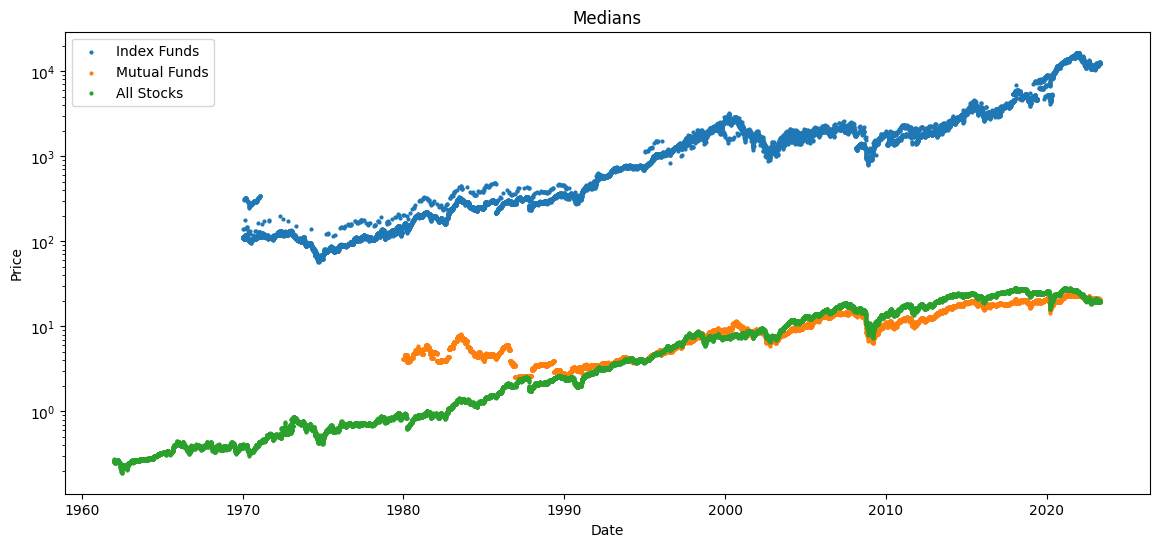

In [133]:
# Index funds, Mutual funds, Stocks in one plot
plt.figure(figsize=(14,6))

plt.scatter(dates_indexes, medians_indexes, label='Index Funds', s=4)
plt.scatter(dates_funds, medians_funds, label='Mutual Funds', s=4)
plt.scatter(dates_stocks, medians_stocks, label='All Stocks', s=4)

plt.yscale('log')
plt.title('Medians')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

There's a significant offset between the index funds and the other two. That could be a calculation error.

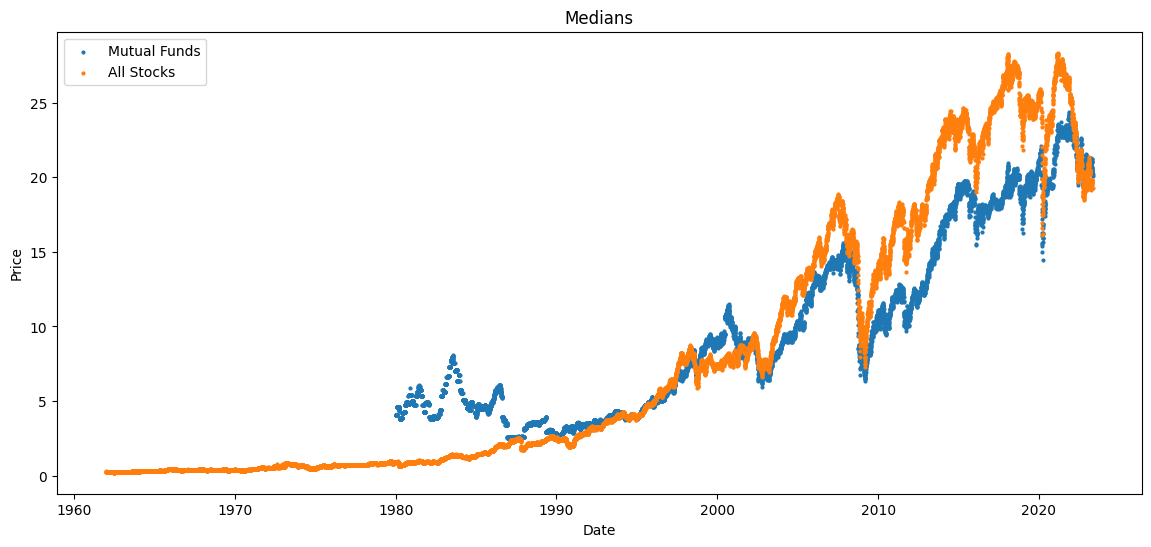

In [134]:
# Let's try mutual funds & only stocks
plt.figure(figsize=(14,6))

plt.scatter(dates_funds, medians_funds, label='Mutual Funds', s=4)
plt.scatter(dates_stocks, medians_stocks, label='All Stocks', s=4)

plt.title('Medians')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Overall these look like very positive trends. Some of those downward spikes correlate with major events like the 2020 pandemic and the 2008 housing crisis, which makes sense

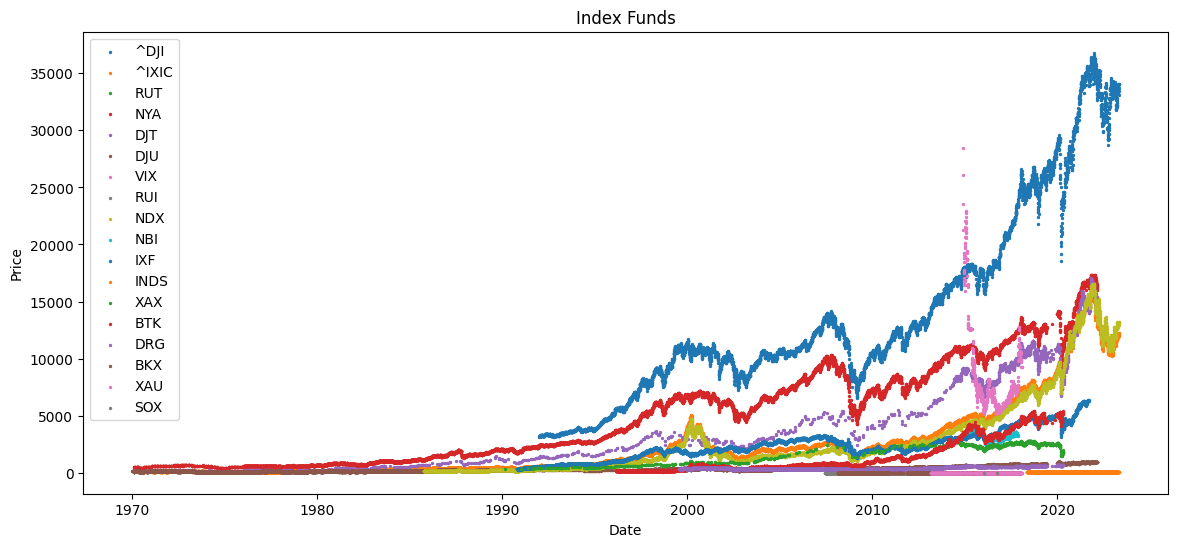

In [93]:
# Index funds
plt.figure(figsize=(14, 6))
for i, df in enumerate(lst_indexes):
    plt.scatter(df['Date'], df['Price'], label=df['Acronym'][0], s=2)

plt.legend()
plt.title('Index Funds')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

I might not have enough data to balance outliers. Or perhaps I need to choose a specific index that's intended to be more representative.

In [97]:
df_indexes.describe()

,Price,Dividends,Security Type
count,85048.000000,85048.0,85048.000000
mean,3425.580048,0.0,4.080825
std,5244.044427,0.0,1.825762
min,0.000570,0.0,2.000000
25%,301.317505,0.0,3.000000
50%,1175.804993,0.0,3.000000
75%,4260.397583,0.0,4.000000
max,36799.648438,0.0,8.000000


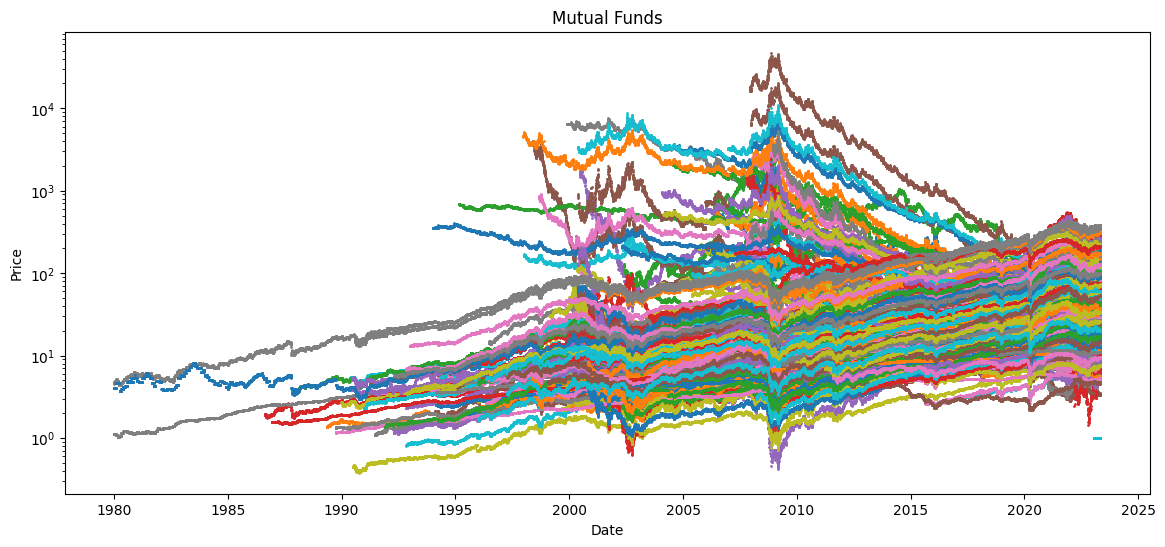

In [94]:
# Mutual funds
plt.figure(figsize=(14,6))
for i, df in enumerate(lst_funds):
    plt.scatter(df['Date'], df['Price'], s=1)

plt.title('Mutual Funds')
plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [98]:
df_funds.describe()

,Price,Dividends,Security Type
count,1.629022e+06,1.629022e+06,1629022.0
mean,7.738380e+01,1.096978e-01,3.0
std,6.287817e+02,4.383661e+01,0.0
min,-1.924721e+04,0.000000e+00,3.0
25%,7.976052e+00,0.000000e+00,3.0
50%,1.396573e+01,0.000000e+00,3.0
75%,3.489605e+01,0.000000e+00,3.0
max,4.720924e+04,3.489528e+04,3.0


In [135]:
df_all.describe()

,Close,Dividends,Security Type
count,3.120949e+07,3.120949e+07,3.120949e+07
mean,1.190958e+09,4.650326e-03,1.177811e+00
std,2.332712e+11,1.518322e+00,3.823537e-01
min,-6.894526e+02,0.000000e+00,1.000000e+00
25%,5.576097e+00,0.000000e+00,1.000000e+00
50%,1.502071e+01,0.000000e+00,1.000000e+00
75%,3.366400e+01,0.000000e+00,1.000000e+00
max,8.675100e+13,3.706250e+03,2.000000e+00


### Prediction

Let's try to predict which security will have the highest increase in the future

In [155]:
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression

In [170]:
n = 365
df_predict['Predict'] = df_indexes[df_indexes['Acronym'] == '^DJI']['Price'].shift(n)
X = np.array(df_predict.drop(['Predict']))
X = preprocessing.scale(X)
X_predict = X[-n:]
X = X[:-n]
y = np.array(df_predict['Predict'])
y = y[:-n]
X, y = X.reshape(-1,1), y.reshape(-1,1)

/var/folders/h6/86cprf7s3kxg1526bnp6tn0w0000gn/T/ipykernel_10613/2187116342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['Predict'] = df_indexes[df_indexes['Acronym'] == '^DJI']['Price'].shift(n)


In [176]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [177]:
model = LinearRegression()
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
accuracy

ValueError: Input y contains NaN.

### Conclusion

In closing, I was not able to make all of the predictions we wanted about the future stock market. However I learned about index funds, mutual funds, and general trends in the stock market. Index funds appear to be more reliable than ordinary stocks, which are much more susceptible to market fluctuations and individual volatility. However the stock market is not as volatile as I thought. The funds indicate a steady increase in the stock market over time. This suggests that for me, as a person looking to invest money without much knowledge of the stock market or frequently checking my investments, index funds are a good option.
